# Loading Libraries

In [2]:
import random
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import model_selection, metrics, preprocessing
from operator import itemgetter
import copy
import torch.nn.functional as F
from torch_geometric.utils import degree

import torch
from torch import nn, optim, Tensor

from torch_sparse import SparseTensor, matmul

from torch_geometric.utils import structured_negative_sampling, to_torch_sparse_tensor
from torch_geometric.data import download_url, extract_zip, HeteroData
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.typing import Adj
from torch_geometric.transforms import RandomLinkSplit


# Loading and Processing MovieLens Dataset

In [3]:
df_movies = pd.read_csv('./ml-latest-small/movies.csv')
df_ratings = pd.read_csv('./ml-latest-small/ratings.csv')

In [29]:
len(df_ratings)

100836

In [4]:
def processing(movies, ratings, rating_threshold=3):
    le = preprocessing.LabelEncoder()
    ratings.userId = le.fit_transform(ratings.userId.values)
    ratings.movieId = le.fit_transform(ratings.movieId.values)

    
    num_users = len(ratings.userId.unique())
    num_movies = len(ratings.movieId.unique())
    src = [user_id for user_id in  ratings['userId']]
    dst = [movie_id for movie_id in ratings['movieId']]
    edge_attr = torch.from_numpy(ratings['rating'].values).to(torch.long) >= rating_threshold
    edge_index = [[], []]
    for i in range(edge_attr.shape[0]):
        if edge_attr[i]:
            edge_index[0].append(src[i])
            edge_index[1].append(dst[i])
    return torch.LongTensor(edge_index), num_users, num_movies

In [5]:
edge_index, num_users, num_movies = processing(df_movies, df_ratings, rating_threshold=3)

In [6]:
all_indices = [i for i in range(edge_index.shape[1])]
train_indices, test_indices = train_test_split(all_indices, test_size=0.2, random_state=1)
val_indices, test_indices = train_test_split(test_indices, test_size=0.5, random_state=1)

In [7]:
train_edge_index = edge_index[:, train_indices]
val_edge_index = edge_index[:, val_indices]
test_edge_index = edge_index[:, test_indices]

# Convert the Interaction Matrix to the Adjacency Matrix

In [8]:
def convert_r_mat_edge_index_to_adj_mat_edge_index(input_edge_index):
    R = torch.zeros(num_users, num_movies)
    for i in range(len(input_edge_index[0])):
        row_idx = input_edge_index[0][i]
        col_idx = input_edge_index[1][i]
        R[row_idx][col_idx] = 1

    R_transpose = torch.transpose(R, 0, 1)
    adj_mat = torch.zeros((num_users + num_movies, num_users + num_movies))
    adj_mat[:num_users, num_users:] = R.clone()
    adj_mat[num_users:, :num_users] = R_transpose.clone()
    adj_mat_coo = adj_mat.to_sparse_coo()
    adj_mat_coo = adj_mat_coo.indices()
    return adj_mat_coo

In [9]:
def convert_adj_mat_edge_index_to_r_mat_edge_index(input_edge_index):
    sparse_input_edge_index = SparseTensor(row = input_edge_index[0],
                                           col = input_edge_index[1],
                                           sparse_sizes = (num_users + num_movies, num_users + num_movies))
    adj_mat = sparse_input_edge_index.to_dense()
    interact_mat = adj_mat[: num_users, num_users:]
    r_mat_edge_index = interact_mat.to_sparse_coo().indices()
    return r_mat_edge_index

In [10]:
train_edge_index = convert_r_mat_edge_index_to_adj_mat_edge_index(train_edge_index)
val_edge_index = convert_r_mat_edge_index_to_adj_mat_edge_index(val_edge_index)
test_edge_index = convert_r_mat_edge_index_to_adj_mat_edge_index(test_edge_index)

# Evaluation Metrics

In [11]:
def RecallPrecision_Atk(groundTruth, r, k):
    num_correct_pred = torch.sum(r, dim=-1)
    user_num_liked = torch.Tensor([len(groundTruth[i]) for i in range(len(groundTruth))])
    recall = torch.mean(num_correct_pred/user_num_liked)
    precision = torch.mean(num_correct_pred)/k
    return recall.item(), precision.item()

In [12]:
def get_metrics(model, input_edge_index, input_exclude_edge_indices, k):
    user_embedding = model.users_emb.weight
    item_embedding = model.items_emb.weight

    edge_index = convert_adj_mat_edge_index_to_r_mat_edge_index(input_edge_index)
    exclude_edge_indices = [convert_adj_mat_edge_index_to_r_mat_edge_index(exclude_edge_indices) for exclude_edge_indices in input_exclude_edge_indices]

    r_mat_rating = torch.matmul(user_embedding, item_embedding.T)

    rating = r_mat_rating

    for exclude_edge_index in exclude_edge_indices:
        user_pos_items = get_user_positive_items(exclude_edge_index)

        exclude_users = []
        exclude_items = []
        for user, items in user_pos_items.items():
            exclude_users.extend([user] * len(items))
            exclude_items.extend(items)

    rating[exclude_users, exclude_items] = -(1<<10)

    _, top_k_items = torch.topk(rating, k=k)
    users = edge_index[0].unique()

    test_user_pos_items = get_user_positive_items(edge_index)
    test_user_pos_items_list = [test_user_pos_items[user.item()] for user in users]

    r = []
    for user in users:
        user_true_relevant_item = test_user_pos_items[user.item()]
        label = list(map(lambda x: x in user_true_relevant_item, top_k_items[user]))
        r.append(label)
    r = torch.Tensor(np.array(r).astype('float'))
    recall, precision = RecallPrecision_Atk(test_user_pos_items_list, r, k)

    return recall, precision

In [13]:
def evaluation(model, edge_index, exclude_edge_indices, k, lambda_val):
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(edge_index)
    r_mat_edge_index = convert_adj_mat_edge_index_to_r_mat_edge_index(edge_index)
    edges = structured_negative_sampling(r_mat_edge_index, contains_neg_self_loops=False)
    
    user_indices, pos_item_indices, neg_item_indices = edges[0], edges[1], edges[2]
    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]

    pos_items_emb_final, pos_items_emb_0 = items_emb_final[pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[neg_item_indices], items_emb_0[neg_item_indices]

    loss = bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0, neg_items_emb_final, neg_items_emb_0, lambda_val)

    recall, precision = get_metrics(model, edge_index, exclude_edge_indices, k)

    return loss, recall, precision

# LightGCN Model

In [14]:
class LightGCN(MessagePassing):
    def __init__(self, num_users, num_items, embedding_dim = 64, K=3, add_self_loops=False):
        super().__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim
        self.K = K
        self.add_self_loops = add_self_loops
        self.users_emb = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.embedding_dim)
        self.items_emb = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.embedding_dim)
        nn.init.normal_(self.users_emb.weight, std=0.1)
        nn.init.normal_(self.items_emb.weight, std=0.1)

    def forward(self, edge_index: Tensor):
        edge_index_norm = gcn_norm(edge_index=edge_index, add_self_loops=self.add_self_loops)

        emb_0 = torch.cat([self.users_emb.weight, self.items_emb.weight])
        embs = [emb_0]
        emb_k = emb_0

        for i in range(self.K):
            emb_k = self.propagate(edge_index=edge_index_norm[0], x=emb_k, norm=edge_index_norm[1])
            embs.append(emb_k)

        embs = torch.stack(embs, dim=1)
        emb_final = torch.mean(embs, dim=1)

        users_emb_final, items_emb_final = torch.split(emb_final, [self.num_users, self.num_items])

        return users_emb_final, self.users_emb.weight, items_emb_final, self.items_emb.weight

    def message(self, x_j, norm):
        return norm.view(-1, 1)*x_j

In [15]:
def get_user_positive_items(edge_index):
    user_pos_items = {}
    for i in range(edge_index.shape[1]):
        user = edge_index[0][i].item()
        item = edge_index[1][i].item()
        if user not in user_pos_items:
            user_pos_items[user] = []

        user_pos_items[user].append(item)
    return user_pos_items

In [16]:
def sample_mini_batch(batch_size, edge_index):
    edges = structured_negative_sampling(edge_index)
    edges = torch.stack(edges, dim=0)
    indices = random.choices([i for i in range(edges[0].shape[0])], k=batch_size)
    batch = edges[:, indices]
    user_indices, pos_item_indices, neg_item_indices = batch[0], batch[1], batch[2]
    return user_indices, pos_item_indices, neg_item_indices

# Bayesian Personalized Ranking (BPR) Loss

In [17]:
def bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0, neg_items_emb_final, neg_items_emb_0, lambda_val):
    reg_loss = lambda_val*((users_emb_0.norm(2).pow(2) + pos_items_emb_0.norm(2).pow(2) + neg_items_emb_0.norm(2).pow(2)))

    pos_scores = torch.mul(users_emb_final, pos_items_emb_final).sum(dim=-1)
    neg_scores = torch.mul(users_emb_final, neg_items_emb_final).sum(dim=-1)
    
    bpr_loss = torch.mean(F.softplus(pos_scores-neg_scores))
    loss = -bpr_loss + reg_loss

    return loss

In [18]:
def get_embs_for_bpr(model, input_edge_index, batch_size, device):
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(input_edge_index)
    edge_index_to_use = convert_adj_mat_edge_index_to_r_mat_edge_index(input_edge_index)
    user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(batch_size, edge_index_to_use)
    user_indices, pos_item_indices, neg_item_indices = user_indices.to(device), pos_item_indices.to(device), neg_item_indices.to(device)

    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[neg_item_indices], items_emb_0[neg_item_indices]

    return users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0, neg_items_emb_final, neg_items_emb_0

# Training

In [23]:
iterations = 5000
batch_size = 1024
lr = 0.001
iter_per_val = 200
iter_per_lr = 200
K=20
LAMBDA = 1e-6
layers = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LightGCN(num_users=num_users, num_items=num_movies, K=layers)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr = lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
val_edge_index = val_edge_index.to(device)

In [24]:
model.train()
train_losses = []
val_losses = []
val_recall_at_ks = []
precision_at_k = []
for iter in range(iterations+1):
    users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0, neg_items_emb_final, neg_items_emb_0 \
    = get_embs_for_bpr(model, train_edge_index, batch_size=batch_size, device=device)

    train_loss = bpr_loss(users_emb_final, users_emb_0,
                          pos_items_emb_final, pos_items_emb_0,
                          neg_items_emb_final, neg_items_emb_0,
                          LAMBDA)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    if iter % iter_per_val == 0:
        model.eval()

        with torch.no_grad():
            val_loss, recall, precision = evaluation(model, val_edge_index, [train_edge_index], K, LAMBDA)

            print(f'[Iteration {iter}/{iterations}] train_loss: {round(train_loss.item(), 5)}, val_loss: {round(val_loss.item(), 5)}, val_recall@{K}: {round(recall, 5)}, val_precision@{K}: {round(precision, 5)}')

            train_losses.append(train_loss.item())
            val_losses.append(val_loss.item())
            val_recall_at_ks.append(round(recall, 5))
            precision_at_k.append(round(precision, 5))
        model.train()

    if iter % iter_per_lr == 0 and iter != 0:
        scheduler.step()

[Iteration 0/5000] train_loss: -0.69195, val_loss: -0.6847, val_recall@20: 0.00198, val_precision@20: 0.00145
[Iteration 200/5000] train_loss: -6.998, val_loss: -5.71851, val_recall@20: 0.04873, val_precision@20: 0.02658
[Iteration 400/5000] train_loss: -28.69919, val_loss: -22.32243, val_recall@20: 0.07086, val_precision@20: 0.03816
[Iteration 600/5000] train_loss: -59.69057, val_loss: -46.75285, val_recall@20: 0.08595, val_precision@20: 0.04353
[Iteration 800/5000] train_loss: -97.49287, val_loss: -77.5948, val_recall@20: 0.08871, val_precision@20: 0.04387
[Iteration 1000/5000] train_loss: -141.83644, val_loss: -112.9658, val_recall@20: 0.09065, val_precision@20: 0.04438
[Iteration 1200/5000] train_loss: -191.45178, val_loss: -150.72174, val_recall@20: 0.09651, val_precision@20: 0.04685
[Iteration 1400/5000] train_loss: -230.75764, val_loss: -191.11255, val_recall@20: 0.10136, val_precision@20: 0.04991
[Iteration 1600/5000] train_loss: -286.49091, val_loss: -233.34886, val_recall@20:

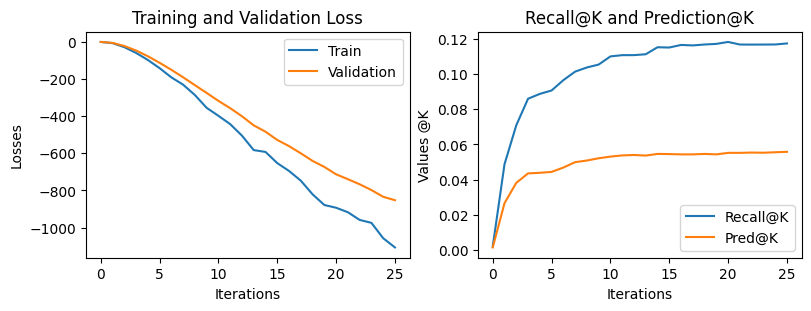

In [25]:
iters = np.arange(len(train_losses))
fig, ax = plt.subplots(1, 2, figsize=(8,3), constrained_layout = True) 

ax[0].plot(iters, train_losses, label='Train')
ax[0].plot(iters, val_losses, label='Validation')
ax[0].set_title('Training and Validation Loss')
ax[0].set_xlabel('Iterations')
ax[0].set_ylabel('Losses')
ax[0].legend()

ax[1].plot(iters, val_recall_at_ks, label='Recall@K')
ax[1].plot(iters, precision_at_k, label='Pred@K')
ax[1].set_title('Recall@K and Prediction@K')
ax[1].set_xlabel('Iterations')
ax[1].set_ylabel('Values @K')
ax[1].legend();

# Evaluation

In [26]:
model.eval()
test_edge_index = test_edge_index.to(device)
test_loss, test_recall, test_precision = evaluation(model, test_edge_index,  [train_edge_index, val_edge_index],  K, LAMBDA)
print(f"Test_loss: {round(test_loss.item(), 5)}, Recall@{K}: {round(test_recall, 5)}, Precision@{K}: {round(test_precision, 5)}")

Test_loss: -862.72223, Recall@20: 0.09566, Precision@20: 0.03691
